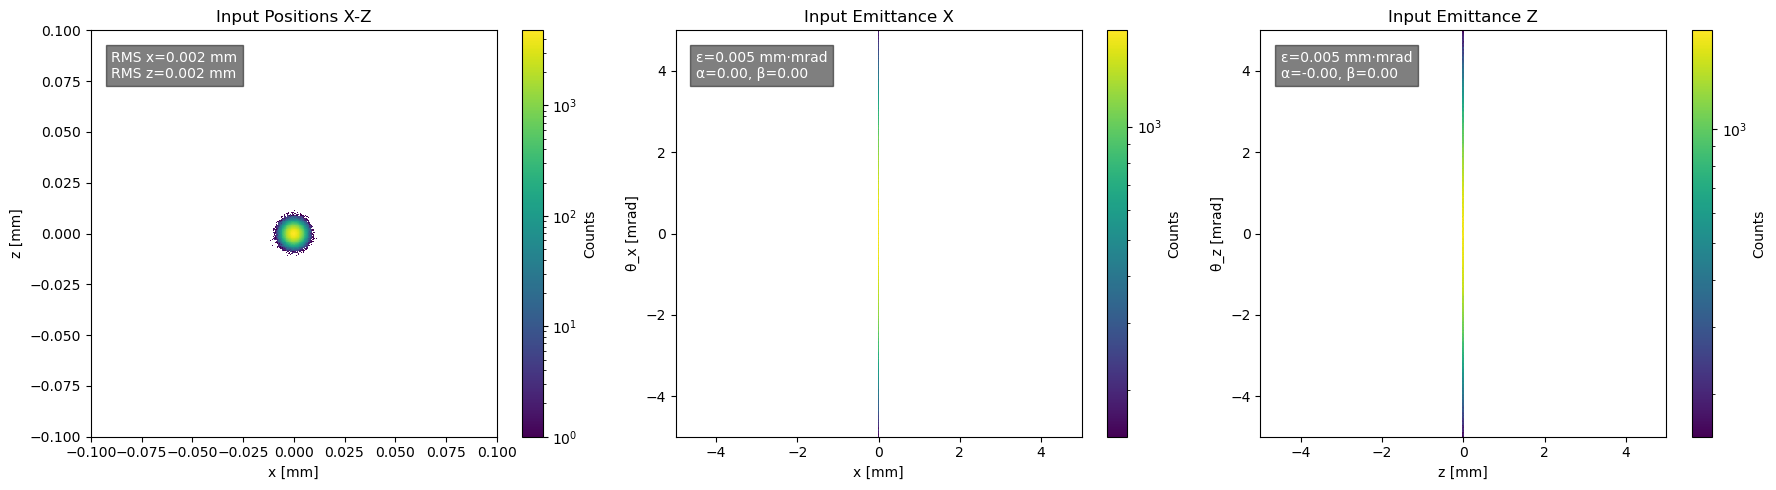

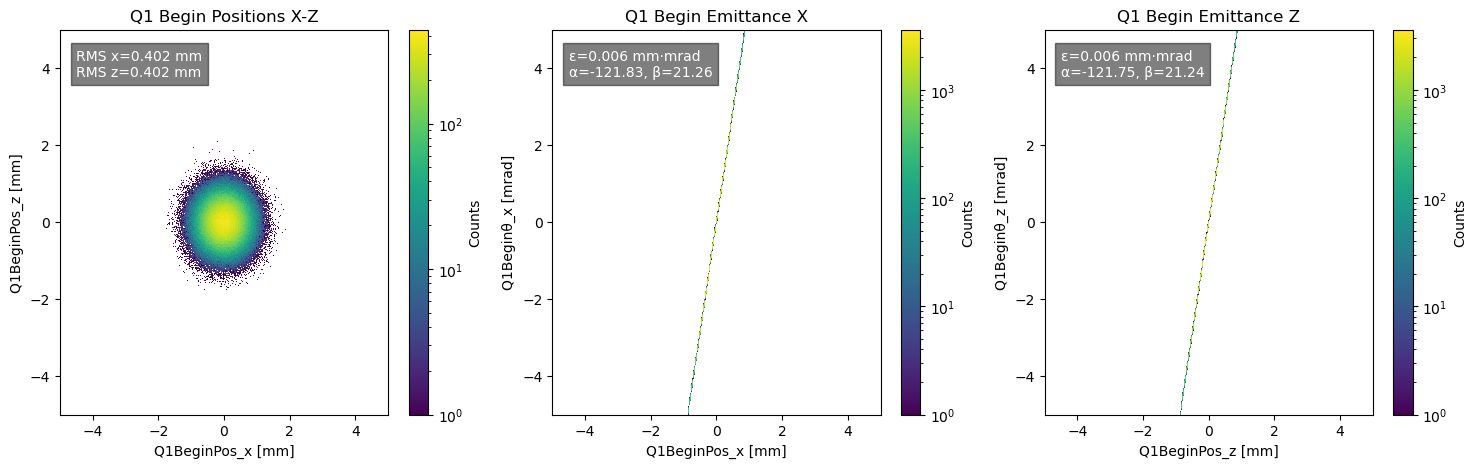

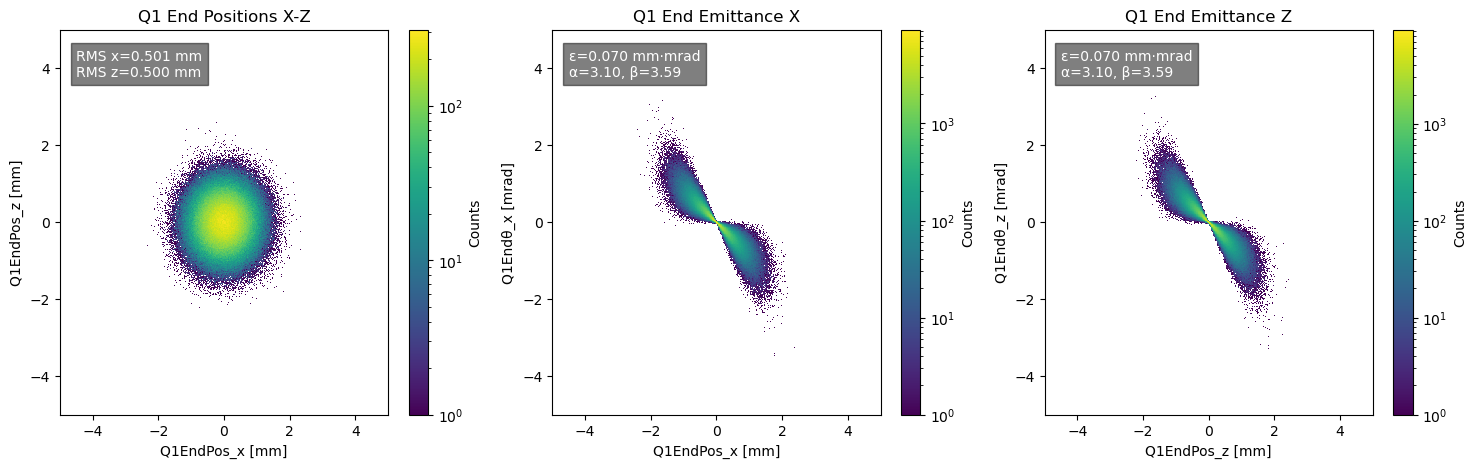

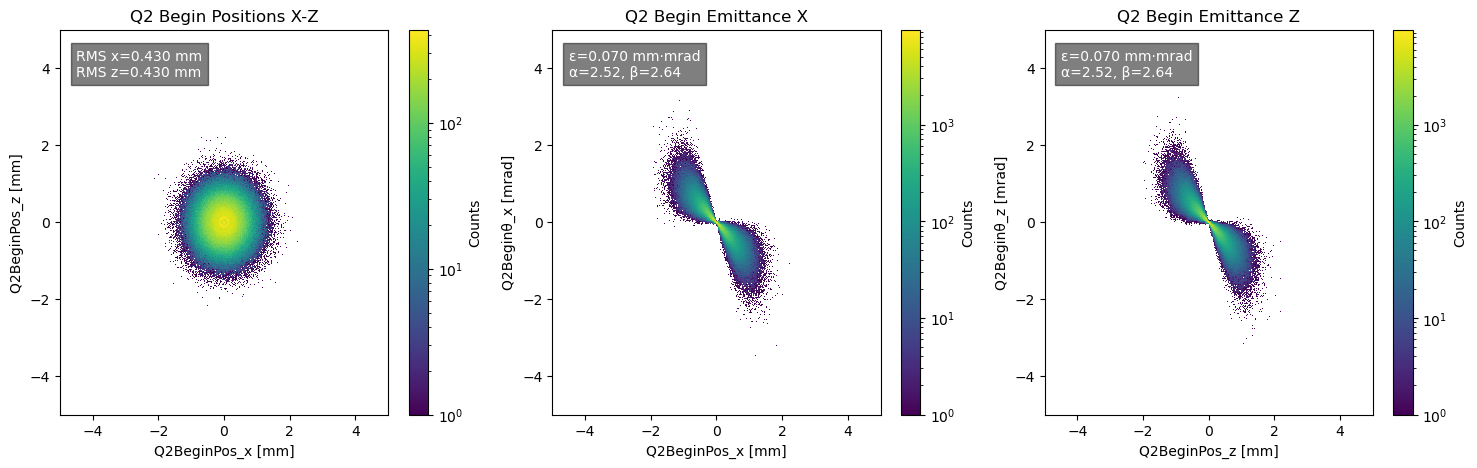

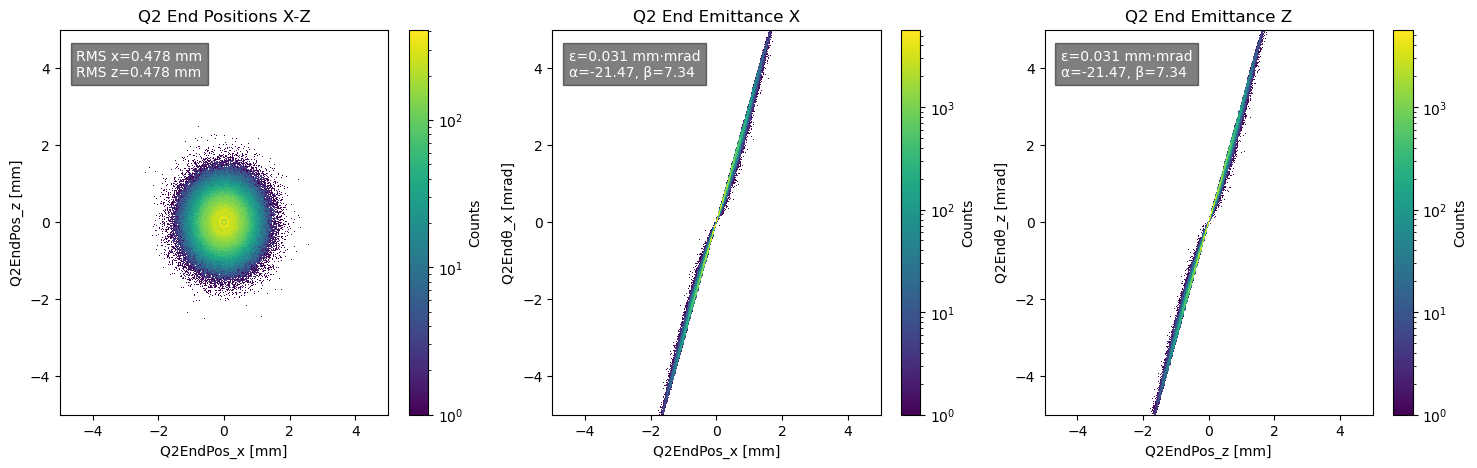

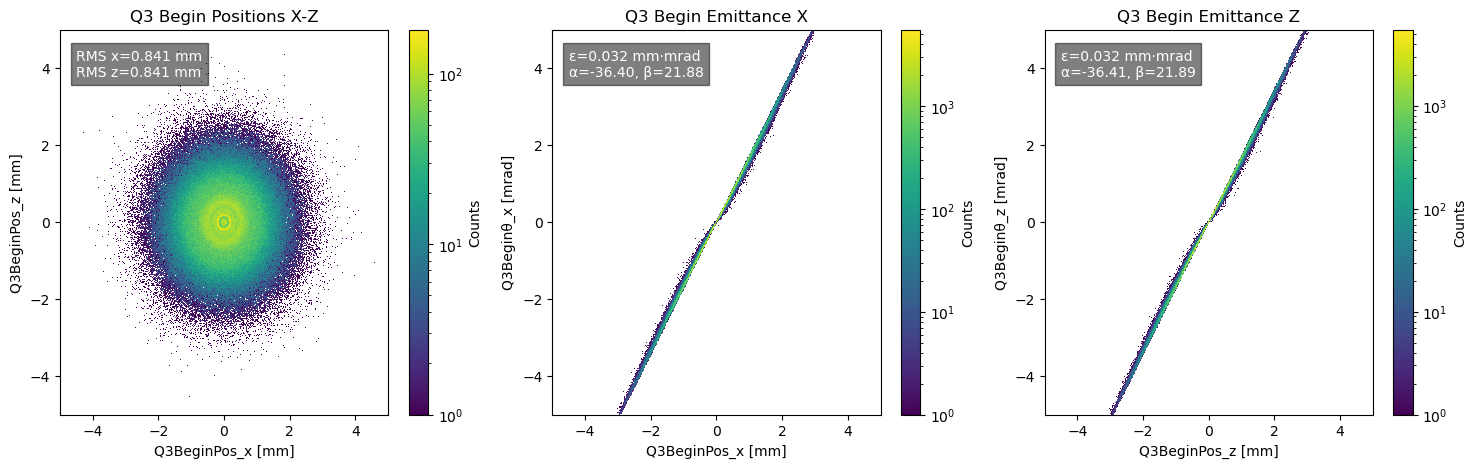

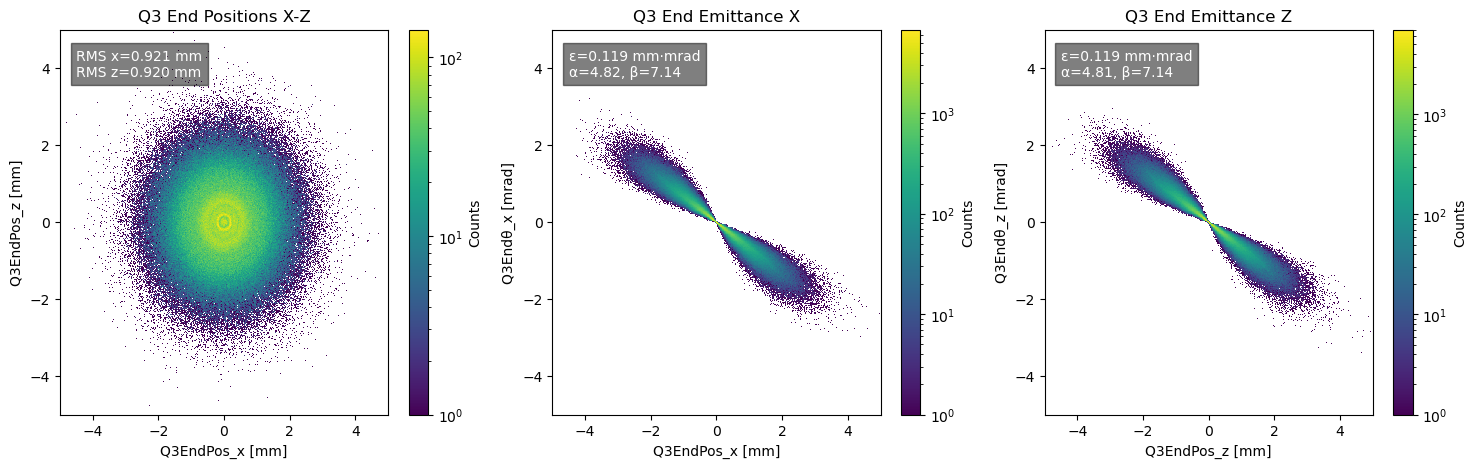

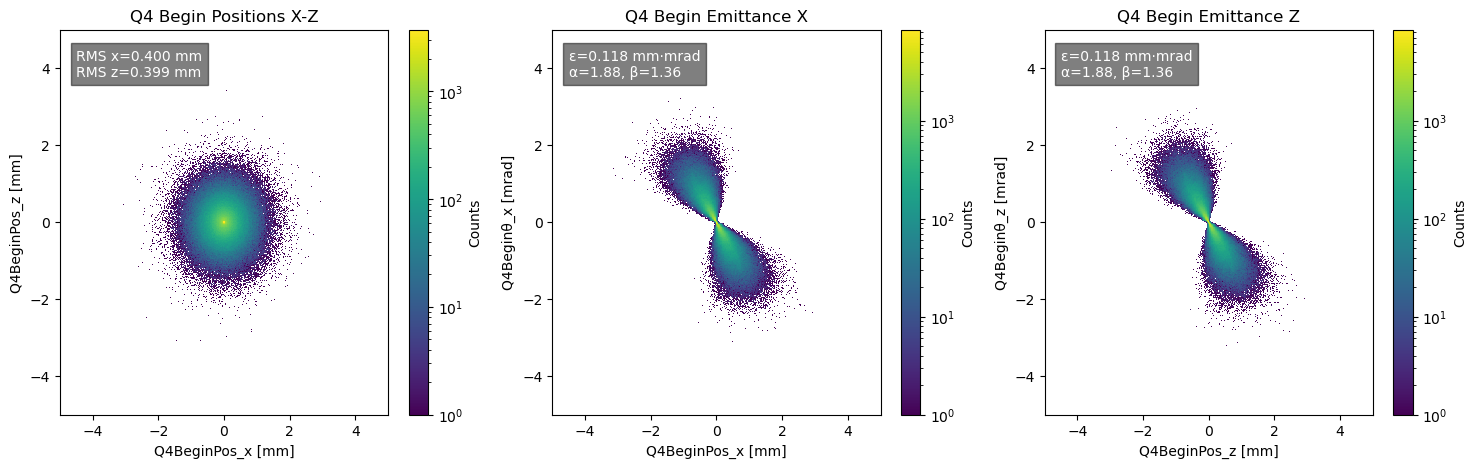

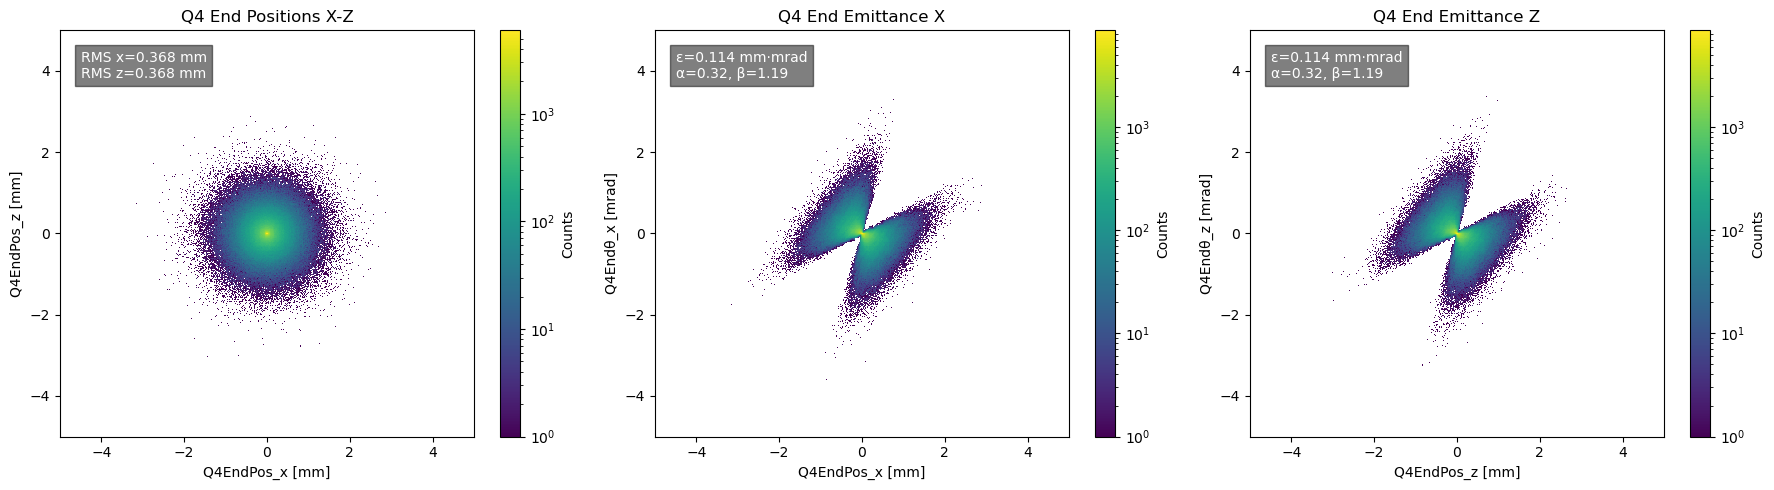

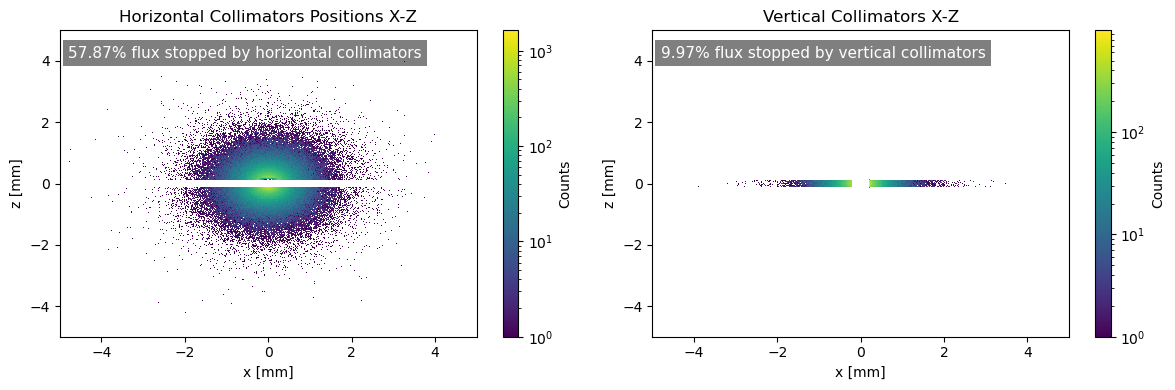

[-0.36535922  0.00828872  0.69327813 ... -0.06092412 -0.39352185
 -0.1355941 ]


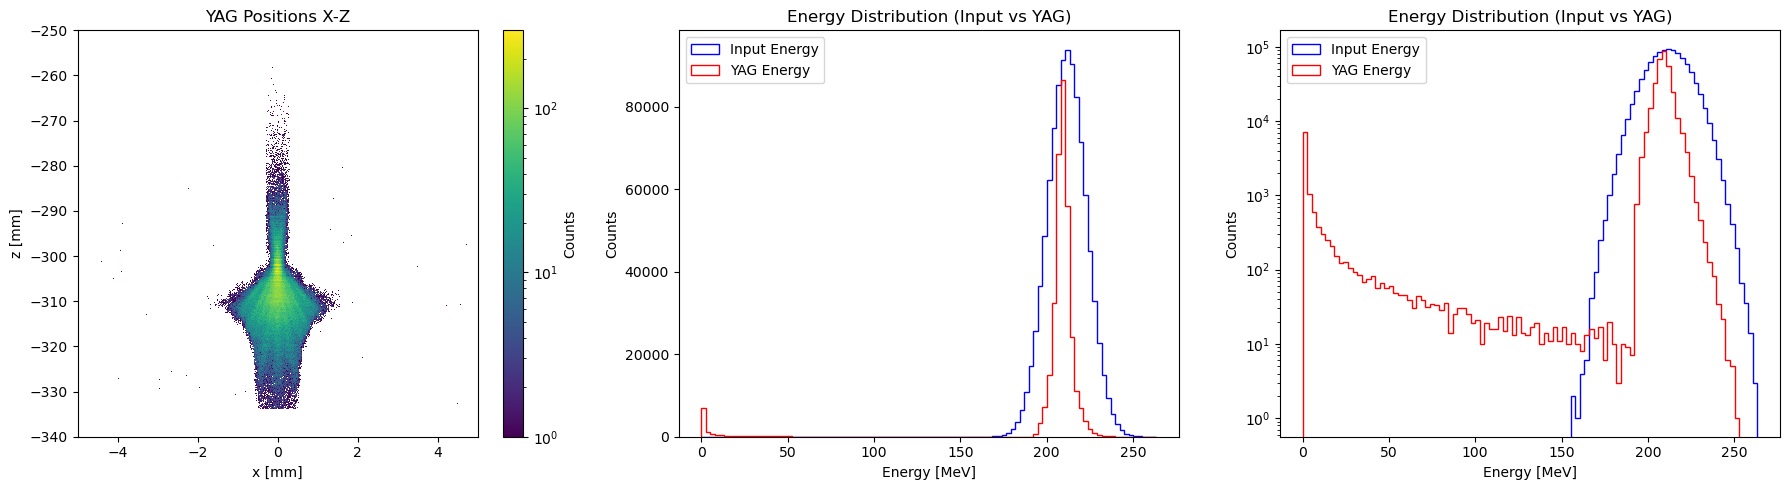

256160

In [70]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import gc

# --- Ouvrir fichier ROOT ---
file = uproot.open(r"D:\Simulations\PlasmaMLPALLAS\Resultats\a.root")

# --- Charger les trees ---
tree_input = file["Input"]
data_input = tree_input.arrays(library="np")

tree_quads = file["QuadrupolesTracking"]
data_quads = tree_quads.arrays(library="np")

tree_horizontalcoll = file["Horizontal_Coll"]
data_horizontalcoll = tree_horizontalcoll.arrays(library="np")

tree_verticalcoll = file["Vertical_Coll"]
data_verticalcoll = tree_verticalcoll.arrays(library="np")

tree_yag = file["BSPECYAG"]
data_yag = tree_yag.arrays(library="np")

# --- Paramètres ---
pos_lim = (-5, 5)              # mm
angle_lim_mrad = (-5, 5)       # mrad pour emittance
bins_pos = 500
bins_angle = 500  # binning plus fin pour angles

quads = ["Q1", "Q2", "Q3", "Q4"]
stages = ["Begin", "End"]

# --- Fonctions de calcul ---
def compute_emittance_and_twiss(x, theta):
    mask = (
        np.isfinite(x) & np.isfinite(theta) &
        (x >= pos_lim[0]) & (x <= pos_lim[1]) &
        (theta >= angle_lim_mrad[0]) & (theta <= angle_lim_mrad[1])
    )
    x = x[mask]
    theta = theta[mask]
    if len(x) < 2:
        return np.nan, np.nan, np.nan, np.nan
    cov = np.cov(np.vstack([x, theta]), ddof=1)
    sig_x2, sig_xt = cov[0,0], cov[0,1]
    sig_t2 = cov[1,1]
    det = sig_x2*sig_t2 - sig_xt**2
    eps = np.sqrt(det) if det > 0 else np.nan
    alpha = -sig_xt/eps if eps > 0 else np.nan
    beta = sig_x2/eps if eps > 0 else np.nan
    gamma = sig_t2/eps if eps > 0 else np.nan
    return eps, alpha, beta, gamma

def compute_rms_size(x):
    mask = np.isfinite(x) & (x >= pos_lim[0]) & (x <= pos_lim[1])
    x = x[mask]
    if len(x) == 0:
        return np.nan
    return np.sqrt(np.mean((x-np.mean(x))**2))

# --- Tracer une ligne pour le tree Input ---
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Positions X-Z
x = data_input["x"]
z = data_input["z"]
Ntot = len(x)
rms_x = compute_rms_size(x)
rms_z = compute_rms_size(z)
h = axes[0].hist2d(x, z, bins=bins_pos, range=[(-0.1,0.1),(-0.1,0.1)],
                    cmap='viridis', norm=LogNorm())
axes[0].set_xlabel("x [mm]")
axes[0].set_ylabel("z [mm]")
axes[0].set_title("Input Positions X-Z")
fig.colorbar(h[3], ax=axes[0], label="Counts")
axes[0].text(0.05, 0.95, f"RMS x={rms_x:.3f} mm\nRMS z={rms_z:.3f} mm",
             transform=axes[0].transAxes, ha="left", va="top",
             color="white", bbox=dict(facecolor="black", alpha=0.5))

# Emittance X (x vs xp)
theta_x = data_input["xp"] * 1000  # mrad
eps_x, alpha_x, beta_x, gamma_x = compute_emittance_and_twiss(x, theta_x)
h = axes[1].hist2d(x, theta_x, bins=[bins_pos, bins_angle],
                    range=[pos_lim, angle_lim_mrad],
                    cmap='viridis', norm=LogNorm())
axes[1].set_xlabel("x [mm]")
axes[1].set_ylabel("θ_x [mrad]")
axes[1].set_title("Input Emittance X")
fig.colorbar(h[3], ax=axes[1], label="Counts")
if not np.isnan(eps_x):
    axes[1].text(0.05, 0.95, f"ε={eps_x:.3f} mm·mrad\nα={alpha_x:.2f}, β={beta_x:.2f}",
                 transform=axes[1].transAxes, ha="left", va="top",
                 color="white", bbox=dict(facecolor="black", alpha=0.5))

# Emittance Z (z vs zp)
theta_z = data_input["zp"] * 1000  # mrad
eps_z, alpha_z, beta_z, gamma_z = compute_emittance_and_twiss(z, theta_z)
h = axes[2].hist2d(z, theta_z, bins=[bins_pos, bins_angle],
                    range=[pos_lim, angle_lim_mrad],
                    cmap='viridis', norm=LogNorm())
axes[2].set_xlabel("z [mm]")
axes[2].set_ylabel("θ_z [mrad]")
axes[2].set_title("Input Emittance Z")
fig.colorbar(h[3], ax=axes[2], label="Counts")
if not np.isnan(eps_z):
    axes[2].text(0.05, 0.95, f"ε={eps_z:.3f} mm·mrad\nα={alpha_z:.2f}, β={beta_z:.2f}",
                 transform=axes[2].transAxes, ha="left", va="top",
                 color="white", bbox=dict(facecolor="black", alpha=0.5))

plt.tight_layout()
plt.show()

# --- Boucle pour chaque quadrupole et stage ---
for q in quads:
    for stage in stages:
        fig, axes = plt.subplots(1, 3, figsize=(18,5))

        # ---- Positions X-Z ----
        x = data_quads[f"{q}{stage}Pos_x"]
        z = data_quads[f"{q}{stage}Pos_z"]
        rms_x = compute_rms_size(x)
        rms_z = compute_rms_size(z)
        h = axes[0].hist2d(x, z, bins=bins_pos, range=[pos_lim,pos_lim],
                            cmap='viridis', norm=LogNorm())
        axes[0].set_xlabel(f"{q}{stage}Pos_x [mm]")
        axes[0].set_ylabel(f"{q}{stage}Pos_z [mm]")
        axes[0].set_title(f"{q} {stage} Positions X-Z")
        fig.colorbar(h[3], ax=axes[0], label="Counts")
        axes[0].text(0.05, 0.95, f"RMS x={rms_x:.3f} mm\nRMS z={rms_z:.3f} mm",
                     transform=axes[0].transAxes, ha="left", va="top",
                     color="white", bbox=dict(facecolor="black", alpha=0.5))

        # ---- Emittance X-θx ----
        theta_x = data_quads[f"{q}{stage}Mom_x"] / data_quads[f"{q}{stage}Mom_y"] * 1000  # mrad
        eps_x, alpha_x, beta_x, gamma_x = compute_emittance_and_twiss(x, theta_x)
        h = axes[1].hist2d(x, theta_x, bins=[bins_pos, bins_angle],
                            range=[pos_lim, angle_lim_mrad],
                            cmap='viridis', norm=LogNorm())
        axes[1].set_xlabel(f"{q}{stage}Pos_x [mm]")
        axes[1].set_ylabel(f"{q}{stage}θ_x [mrad]")
        axes[1].set_title(f"{q} {stage} Emittance X")
        fig.colorbar(h[3], ax=axes[1], label="Counts")
        if not np.isnan(eps_x):
            axes[1].text(0.05, 0.95, f"ε={eps_x:.3f} mm·mrad\nα={alpha_x:.2f}, β={beta_x:.2f}",
                         transform=axes[1].transAxes, ha="left", va="top",
                         color="white", bbox=dict(facecolor="black", alpha=0.5))

        # ---- Emittance Z-θz ----
        theta_z = data_quads[f"{q}{stage}Mom_z"] / data_quads[f"{q}{stage}Mom_y"] * 1000  # mrad
        eps_z, alpha_z, beta_z, gamma_z = compute_emittance_and_twiss(z, theta_z)
        h = axes[2].hist2d(z, theta_z, bins=[bins_pos, bins_angle],
                            range=[pos_lim, angle_lim_mrad],
                            cmap='viridis', norm=LogNorm())
        axes[2].set_xlabel(f"{q}{stage}Pos_z [mm]")
        axes[2].set_ylabel(f"{q}{stage}θ_z [mrad]")
        axes[2].set_title(f"{q} {stage} Emittance Z")
        fig.colorbar(h[3], ax=axes[2], label="Counts")
        if not np.isnan(eps_z):
            axes[2].text(0.05, 0.95, f"ε={eps_z:.3f} mm·mrad\nα={alpha_z:.2f}, β={beta_z:.2f}",
                         transform=axes[2].transAxes, ha="left", va="top",
                         color="white", bbox=dict(facecolor="black", alpha=0.5))

plt.tight_layout()
plt.show()


# --- Tracer une ligne pour les trees Coll/YAG ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Positions X-Z Horizontal Coll
x_hc = data_horizontalcoll["x_interaction"]
z_hc = data_horizontalcoll["z_interaction"]

frac_stopped_hc = len(x_hc) / Ntot * 100  # pourcentage

h = axes[0].hist2d(
    x_hc, z_hc, bins=bins_pos, range=[pos_lim, pos_lim],
    cmap="viridis", norm=LogNorm()
)
axes[0].set_xlabel("x [mm]")
axes[0].set_ylabel("z [mm]")
axes[0].set_title("Horizontal Collimators Positions X-Z")

# Ajout du texte dans le plot
axes[0].annotate(
    f"{frac_stopped_hc:.2f}% flux stopped by horizontal collimators",
    xy=(0.02, 0.95), xycoords="axes fraction",   # coordonnées relatives à l'axe
    fontsize=11, color="white",
    ha="left", va="top", 
    bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")  # fond noir translucide
)

fig.colorbar(h[3], ax=axes[0], label="Counts")




# Positions X-Z Vertical Coll
x_vc = data_verticalcoll["x_interaction"]
z_vc = data_verticalcoll["z_interaction"]
frac_stopped_vc = len(x_vc) / Ntot * 100  # pourcentage
h = axes[1].hist2d(x_vc, z_vc, bins=bins_pos,range=[pos_lim,pos_lim],
                    cmap='viridis', norm=LogNorm())
axes[1].set_xlabel("x [mm]")
axes[1].set_ylabel("z [mm]")
axes[1].set_title("Vertical Collimators X-Z")
# Ajout du texte dans le plot
axes[1].annotate(
    f"{frac_stopped_vc:.2f}% flux stopped by vertical collimators",
    xy=(0.02, 0.95), xycoords="axes fraction",   # coordonnées relatives à l'axe
    fontsize=11, color="white",
    ha="left", va="top", 
    bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")  # fond noir translucide
)
fig.colorbar(h[3], ax=axes[1], label="Counts")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Positions X-Z YAG
x_yag = np.concatenate([arr for arr in data_yag["x_exit"]])
z_yag = np.concatenate([arr for arr in data_yag["z_exit"]])

print(x_yag)
h = axes[0].hist2d(x_yag, z_yag, bins=bins_pos,range=[(-5,5),(-340,-250)],
                    cmap='viridis', norm=LogNorm())
axes[0].set_xlabel("x [mm]")
axes[0].set_ylabel("z [mm]")
axes[0].set_title("YAG Positions X-Z")
fig.colorbar(h[3], ax=axes[0], label="Counts")

# --- Plot 2 : Histogramme d'énergie Input vs YAG ---
energy_input = np.array(data_input["energy"])         # déjà ok
energy_yag   = np.concatenate(data_yag["energy"])     # aplatit la liste d'arrays

# Histogramme comparatif
axes[1].hist(energy_input, bins=100, range=(0, np.max(energy_input)),
             histtype="step", color="blue", label="Input Energy")

axes[1].hist(energy_yag, bins=100, range=(0, np.max(energy_input)),
             histtype="step", color="red", label="YAG Energy")

# Mise en forme
axes[1].set_xlabel("Energy [MeV]")
axes[1].set_ylabel("Counts")
axes[1].set_title("Energy Distribution (Input vs YAG)")
axes[1].legend()

# --- Plot 2 : Histogramme d'énergie Input vs YAG ---

# Histogramme comparatif
axes[2].hist(energy_input, bins=100, range=(0, np.max(energy_input)),
             histtype="step", color="blue", label="Input Energy")

axes[2].hist(energy_yag, bins=100, range=(0, np.max(energy_input)),
             histtype="step", color="red", label="YAG Energy")

# Mise en forme
axes[2].set_xlabel("Energy [MeV]")
axes[2].set_ylabel("Counts")
axes[2].set_title("Energy Distribution (Input vs YAG)")
axes[2].set_yscale("log")
axes[2].legend()

plt.tight_layout()
plt.show()


# --- Nettoyage mémoire ---
del data_input, data_quads, tree_input, tree_quads, file
gc.collect()